# $$\varpi \equiv \kappa\nabla^2 b = \kappa \Big[\frac{\partial b}{\partial \theta} (\nabla^2 \theta) + \frac{\partial b}{\partial s} (\nabla^2 s)\Big]$$

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:53322")
client

Client Scheduler: tcp://127.0.0.1:53322 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 40 Memory: 169.33 GB


In [2]:
import numpy as np
import xarray as xr
# from dask.diagnostics import ProgressBar
import os.path as op
import xrft
import gsw
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid as xgrid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 23
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rho0 = 9.998e2
Cp = 3.994e3
ystart = -10
yend = 50
t_of_interest = 1

In [38]:
xchunk = 500

for memb in range(24,26):
    if memb == 24:
        dsocn = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % memb), 
                                grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                prefix = ['diag_Tbgt2D','diag_Tbgt3D',
                                          'diag_Sbgt2D','diag_Sbgt3D',
                                          'diag_ocnSnap'], delta_t = 2e2
                               ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk})

#         dsaml = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run2012/cheapaml/' % memb),
#                                 grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                 prefix = ['diag_cheapAML'], delta_t = 2e2
#                                ).isel(time=slice(None,3)).chunk({'XC':xchunk,'XG':xchunk})
    else:
        dsocn = xr.concat([dsocn,open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % memb), 
                                                 grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                 prefix = ['diag_Tbgt2D','diag_Tbgt3D',
                                                           'diag_Sbgt2D','diag_Sbgt3D',
                                                           'diag_ocnSnap'], delta_t = 2e2
                                                ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk})
                          ], dim='nmemb')
dsocn

/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/tank/users/tuchida/miniconda3/envs/ensemble/lib/python3.7/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option

<xarray.Dataset>
Dimensions:   (XC: 1000, XG: 1000, YC: 900, YG: 900, Z: 46, Zl: 46, Zp1: 47, Zu: 46, nmemb: 2)
Coordinates:
    time      float64 1.577e+08
    rAs       (YG, XC) >f4 83319550.0 83319550.0 ... 50896490.0 50896490.0
    hFacS     (Z, YG, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    PHrefC    (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    maskS     (Z, YG, XC) bool True True True True ... False False False False
    hFacW     (Z, YC, XG) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    dxG       (YG, XC) >f4 8993.141 8993.141 8993.141 ... 5493.54 5493.54
    maskInW   (YC, XG) bool False False False False ... False False False False
    dxC       (YC, XG) >f4 8995.514 8995.514 8995.514 ... 5487.842 5487.842
    rA        (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    maskW     (Z, YC, XG) bool True True True True ... False False False False
    maskInS   (YG, XC) bool False False False False ... True True True True


In [16]:
grid = xgrid(dsocn, periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [58]:
Vol_r = dsocn.rA**-1 * dsocn.drF**-1 * dsocn.hFacC**-1
xA = dsocn.hFacW * dsocn.dyG * dsocn.drF
yA = dsocn.hFacS * dsocn.dxG * dsocn.drF
dxC_r = dsocn.dxC**-1
dyC_r = dsocn.dyC**-1
dxG_r = dsocn.dxG**-1
dyG_r = dsocn.dyG**-1
rA_r = dsocn.rA**-1
Vol_r

<xarray.DataArray (YC: 900, XC: 1000, Z: 46)>
array([[[1.9691029e-09, 1.7852710e-09, 1.6902538e-09, ...,
                   inf,           inf,           inf],
        [1.9691029e-09, 1.7852710e-09, 1.6902538e-09, ...,
                   inf,           inf,           inf],
        [1.9691029e-09, 1.7852710e-09, 1.6902538e-09, ...,
                   inf,           inf,           inf],
        ...,
        [1.9691029e-09, 1.7852710e-09, 1.6902538e-09, ...,
                   inf,           inf,           inf],
        [1.9691029e-09, 1.7852710e-09, 1.6902538e-09, ...,
                   inf,           inf,           inf],
        [1.9691029e-09, 1.7852710e-09, 1.6902538e-09, ...,
                   inf,           inf,           inf]],

       [[1.9680679e-09, 1.7843326e-09, 1.6893654e-09, ...,
                   inf,           inf,           inf],
        [1.9680679e-09, 1.7843326e-09, 1.6893654e-09, ...,
                   inf,           inf,           inf],
        [1.9680679e-09, 1.7

In [34]:
DiffE = - (-grid.diff(dsocn.DFrE_TH,'Z',boundary='fill') * Vol_r
           + grid.diff(dsocn.DFxE_TH,'X') * Vol_r
           + grid.diff(dsocn.DFyE_TH,'Y',boundary='fill') * Vol_r
          ).where(dsocn.maskC!=0.)
DiffI = (grid.diff(dsocn.DFrI_TH,'Z',boundary='fill') * Vol_r).where(dsocn.maskC!=0.)
Kpp = grid.diff(dsocn.KPPg_TH.where(dsocn.maskInC!=0.),'Z',boundary='fill') * Vol_r
swfrac = .62 * np.exp(dsocn.Zl/.6) + (1-.62) * np.exp(dsocn.Zl/20.)
swfrac1 = .62 * np.exp(dsocn.Zl.shift(Zl=-1)/.6) + (1-.62) * np.exp(dsocn.Zl.shift(Zl=-1)/20.)
Qsw = (dsocn.oceQsw / (rho0*Cp) / (dsocn.drF*dsocn.hFacC) 
       * (swfrac - swfrac1).data
      ).where(dsocn.maskC!=0.)
Tflx = ((dsocn.TFLUX - dsocn.oceQsw) 
        / (rho0*Cp*dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
       ).where(dsocn.maskInC!=0.)
tsurf_corr = 0.  # linFSConverveTr = F.
Surf_corr = (tsurf_corr - dsocn.WTHMASS[:,0].where(dsocn.maskInC!=0.)
            ) / (dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
DibaT = (DiffE + DiffI + Kpp + Qsw).load()
DibaT[:,0] += (Tflx + Surf_corr).load().data
DibaT.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan # exclude Mediterranian relaxation
DibaT

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-9.6621379e-06, -9.5092428e-06, -1.0387937e-05, ...,
          -7.6660926e-06, -7.8511312e-06, -8.7574936e-06],
         [-8.0348073e-06, -7.0048786e-06, -6.8059253e-06, ...,
          -7.8241983e-06, -7.8001876e-06, -8.3260838e-06],
         ...,
         [-9.8974397e-07,  7.0188946e-07,  8.5971942e-07, ...,
          -2.4723266e-07, -7.3280125e-07, -1.2062429e-06],
         [-1.2982016e-06,  2.6693871e-07,  3.9824602e-07, ...,
          -7.3035045e-07, -1.1976334e-06, -1.5277043e-06],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [ 1.4966163e-06,  2.4203034e-06,  3.0164713e-06, ...,
           

In [35]:
DiffE = - (-grid.diff(dsocn.DFrE_SLT,'Z',boundary='fill') * Vol_r
           + grid.diff(dsocn.DFxE_SLT,'X') * Vol_r
           + grid.diff(dsocn.DFyE_SLT,'Y',boundary='fill') * Vol_r
          ).where(dsocn.maskC!=0.)
DiffI = (grid.diff(dsocn.DFrI_SLT,'Z',boundary='fill') * Vol_r).where(dsocn.maskC!=0.)
Kpp = grid.diff(dsocn.KPPg_SLT.where(dsocn.maskInC!=0.),'Z',boundary='fill') * Vol_r
Sflx = (dsocn.SFLUX 
        / (rho0*dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
       ).where(dsocn.maskInC!=0.)
ssurf_corr = 0.  # linFSConverveTr = F.
Surf_corr = (ssurf_corr - dsocn.WSLTMASS[:,0].where(dsocn.maskInC!=0.)
            ) / (dsocn.drF[0]*dsocn.hFacC.isel(Z=0))
DibaS = (DiffE + DiffI + Kpp).load()
DibaS[:,0] += (Sflx + Surf_corr).load().data
DibaS.sel(XC=slice(268,268.3),YC=slice(35.75,36.1))[:] = np.nan
DibaS

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [-6.96813913e-08, -7.07455570e-08, -6.58648673e-08, ...,
          -1.66865277e-07, -1.34897405e-07, -8.92233629e-08],
         [-7.32641396e-08, -9.15064717e-08, -9.92766260e-08, ...,
          -1.35127678e-07, -1.17853745e-07, -8.54999982e-08],
         ...,
         [ 5.27351531e-08,  4.60823335e-09, -2.71164655e-08, ...,
           9.00551882e-08,  7.20601605e-08,  6.82864965e-08],
         [ 4.76446935e-08,  6.27128349e-09, -4.95902563e-09, ...,
           6.18368503e-08,  6.45586411e-08,  6.22014227e-08],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 1.74994312e-07,  8.20

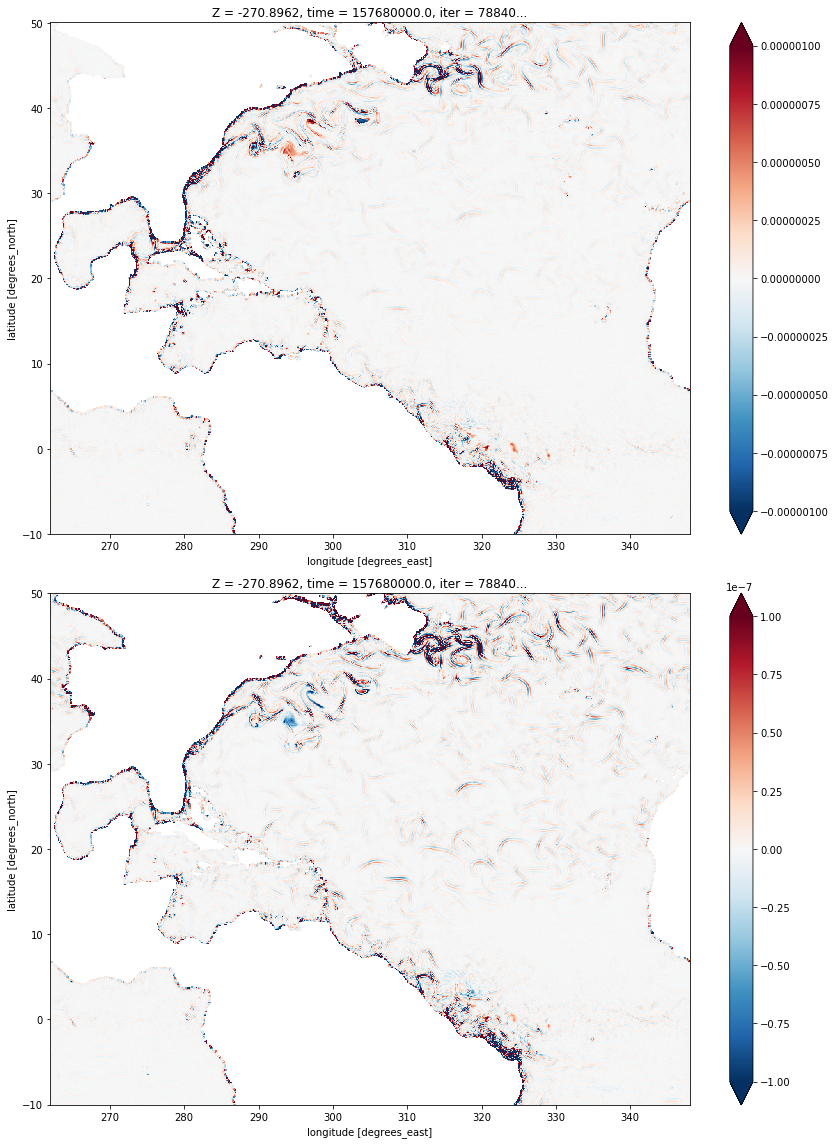

In [36]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,16))
fig.set_tight_layout(True)
DibaT[0,15].sel(YC=slice(-10,50+12**-1)).plot(ax=ax1, vmax=1e-6)
DibaS[0,15].sel(YC=slice(-10,50+12**-1)).plot(ax=ax2, vmax=1e-7)

In [39]:
rho2 = xr.apply_ufunc(jmd95.densjmd95, dsocn.SALT, dsocn.THETA, 20e2, 
                     dask='parallelized', output_dtypes=[float]
                     )
# rho2x = xr.apply_ufunc(jmd95.densjmd95, gridz.interp(dsocn.SALT,'X'), gridz.interp(dsocn.THETA,'X'), 20e2, 
#                       dask='parallelized', output_dtypes=[float]
#                       )
# rho2y = xr.apply_ufunc(jmd95.densjmd95, gridz.interp(dsocn.SALT,'Y',boundary='fill'), 
#                       gridz.interp(dsocn.THETA,'Y',boundary='fill'), 20e2, 
#                       dask='parallelized', output_dtypes=[float]
#                       )
rho2

<xarray.DataArray (nmemb: 2, Z: 46, YC: 900, XC: 1000)>
dask.array<densjmd95, shape=(2, 46, 900, 1000), dtype=float64, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
    time     float64 1.577e+08
    PHrefC   (Z) >f4 29.88884 92.74422 160.5305 ... 55180.777 57635.133
    rA       (YC, XC) >f4 83341540.0 83341540.0 ... 50843696.0 50843696.0
    iter     int64 788400
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    hFacC    (Z, YC, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskInC  (YC, XC) bool False False False False ... False False False False
    drF      (Z) >f4 6.0935454 6.721007 7.098827 ... 249.91599 250.46292
    Depth    (YC, XC) >f4 3440.756 3215.3306 2099.5483 ... 2916.6108 2823.8076
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * YC       (YC) >f4 -19.916634 -19.8333 -19.749968 ... 54.916702 55

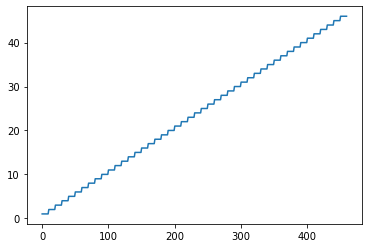

In [40]:
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(dsocn.drF.sel(Z=slice(None,None))),
                                                            np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
                                                            10)
# drc_finer, _, _, _ = finegrid.finegrid(np.squeeze(dsocn.drC.isel(Zp1=slice(None,-1))),
#                                       np.squeeze(dsocn.drC.sel(Zp1=slice(None,None))),
#                                       10)

plt.plot(cellindex)

In [41]:
Dsig = 9.7
nlayers = 43

tmp = np.tanh(np.linspace(-2.,2.75,nlayers))
tmp += np.abs(tmp.min())
tmp *= tmp.max()**-1 * Dsig
# print(tmp)
siglayers = 27.5 + tmp
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))

In [76]:
GTdz = xr.DataArray(np.ones((len(dsocn.nmemb),
                             len(dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1))),
                             len(dsocn.XC),len(siglayers))),
                    dims=['nmemb','YC','XC','sig'],
                    coords={'nmemb':range(2),
                            'YC':dsocn.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).data,
                            'XC':dsocn.XC.data,'sig':siglayers}
                   ) * np.nan
Gsdz = GTdz.copy()
Tdz = GTdz.copy()
sdz = GTdz.copy()

for tt in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          DibaT[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                        yend+2*12**-1)
                                                              ).chunk({'Z':-1,'YC':-1,
                                                                       'XC':xchunk}),
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp2 = xr.apply_ufunc(layers_numpy, 
                          DibaS[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                        yend+2*12**-1)
                                                              ).chunk({'Z':-1,'YC':-1,
                                                                       'XC':xchunk}),      
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
    
    tmp3 = xr.apply_ufunc(layers_numpy, 
                          dsocn.THETA[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                              yend+2*12**-1)
                                                                    ),
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized',
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

    tmp4 = xr.apply_ufunc(layers_numpy, 
                          dsocn.SALT[tt].where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ),      
                          (rho2[tt]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                             yend+2*12**-1)
                                                                   ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
        #                            output_core_dims=(['sig2lev']),
        #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()

        
#     if tt == 0:
#         GTdz = tmp1
#         Gsdz = tmp2
# #         dzetaF = tmpdzetaF
#     else:
#         GTdz = xr.concat([GTdz, tmp1], dim='nmemb')
#         Gsdz = xr.concat([Gsdz, tmp2], dim='nmemb')
# #         dzetaF = xr.concat([dzetaF, tmpdzetaF], dim='time')
    GTdz[tt] = tmp1
    Gsdz[tt] = tmp2
    Tdz[tt] = tmp3
    sdz[tt] = tmp4
    
    del tmp1, tmp2, tmp3, tmp4

    
GTdz = GTdz.chunk({'nmemb':1,'sig':1})
Gsdz = Gsdz.chunk({'nmemb':1,'sig':1})
Tdz = Tdz.chunk({'nmemb':1,'sig':1})
sdz = sdz.chunk({'nmemb':1,'sig':1})
GTdz

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [53]:
dzetaF = GTdz.load().copy() * np.nan
# dzetaF.coords['time'] = ('time',ds.time.data)

for j in range(2):
    tmp1 = xr.apply_ufunc(layers_numpy, 
                          xr.ones_like(rho2[j]).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                                    yend+2*12**-1)
                                                                          ).chunk({'XC':xchunk}),
                          (rho2[j]-1e3).where(dsocn.maskC!=0.).sel(YC=slice(ystart-12**-1,
                                                                            yend+2*12**-1)
                                                                  ).chunk({'XC':xchunk}),
                          kwargs={'thetalayers':siglayers,'mapfact':mapfact,
                                  'mapindex':mapindex,'cellindex':cellindex,
                                  'drf_finer':drf_finer},
                          dask='parallelized', 
                          input_core_dims=[['Z'],['Z']], 
                          output_core_dims=[['sig']],
            #                            output_core_dims=(['sig2lev']),
            #                            exclude_dims=set(['Z']),
                          output_dtypes=[float,], output_sizes={'sig':siglayers.size}
                         ).compute()
            
    dzetaF[j] = tmp1.data
    
    del tmp1
    
dzetaF = dzetaF.chunk({'nmemb':1,'sig':1})
dzetaF

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<xarray-<this-array>, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [54]:
dssig = dzetaF.to_dataset(name='dzetaF')
dssig.coords['YG'] = ('YG',dsocn.YG.sel(YG=slice(ystart-12**-1,yend+2*12**-1)).data)
dssig.coords['XG'] = ('XG',dsocn.XG.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
# dssig.coords['rAs'] = (('YG','XC'),vdz.rAs.data)
# dssig.coords['rAw'] = (('YC','XG'),udz.rAw.data)
dssig.coords['sigp1'] = ('sigp1',sigp1layers)
# dt = np.diff(ds.time)[0]
# dssig.coords['timep1'] = ('timep1',np.append(np.append(ds.time[0].data-.5*dt,
#                                                        .5*(ds.time[1:].data+ds.time[:-1].data)),
#                                              ds.time[-1].data+.5*dt))
dssig

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 723, YG: 723, nmemb: 2, sig: 43, sigp1: 44)
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
  * YG       (YG) >f4 -10.041633 -9.9583 -9.874967 ... 50.041702 50.125034
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * sigp1    (sigp1) float64 27.48 27.52 27.57 27.63 ... 37.17 37.18 37.19 37.21
Data variables:
    dzetaF   (nmemb, YC, XC, sig) float64 dask.array<chunksize=(1, 723, 1000, 1), meta=np.ndarray>

In [55]:
grids = xgrid(dssig, periodic=['X'], 
              coords={'Z':{'center':'sig','outer':'sigp1'},
                      'Y':{'center':'YC','left':'YG'},
                      'X':{'center':'XC','left':'XG'}}
             )
grids

<xgcm.Grid>
Z Axis (not periodic):
  * center   sig --> outer
  * outer    sigp1 --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

In [96]:
sigma = (dzetaF * grids.diff(dssig.sigp1,'Z',boundary='fill')**-1)
zeta = -grids.interp(grids.cumsum(dzetaF,'Z',boundary='fill'),'Z',boundary='fill')
sigma

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<mul, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2

In [63]:
angle = np.sqrt(1 + (dzetaF/grid.interp(dsocn.dxG,'Y',boundary='fill'))**2 
                + (dzetaF/grid.interp(dsocn.dyG,'X'))**2
               )**-1
angley = np.sqrt(1 + (grids.interp(dzetaF,'Y',boundary='fill')/dsocn.dxG)**2 
                + (grids.interp(dzetaF,'Y',boundary='fill')
                   / grid.interp(grid.interp(dsocn.dyG,'X'),'Y',boundary='fill')
                  )**2
                )**-1
anglex = np.sqrt(1 + (grids.interp(dzetaF,'X')
                      / grid.interp(grid.interp(dsocn.dxG,'Y',boundary='fill'),'X')
                     )**2 
                + (grids.interp(dzetaF,'X')/dsocn.dyG)**2
                )**-1
anglez = np.sqrt(1 + (grids.interp(dzetaF,'Z',boundary='fill')
                      / grid.interp(dsocn.dxG,'Y',boundary='fill')
                     )**2 
                 + (grids.interp(dzetaF,'Z',boundary='fill')
                    / grid.interp(dsocn.dyG,'X')
                   )**2
                )**-1
print(angle,angley,anglex,anglez)

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<pow, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2 <xarray.DataArray (nmemb: 2, YG: 723, XC: 1000, sig: 43)>
dask.array<pow, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 722, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) float64 -10.04 -9.958 -9.875 -9.792 ... 49.96 50.04 50.13
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
    time     float64 1.577e+08
    rAs      (YG, XC) >f4 87285460.0 87285460.0 ... 56830530.0 56830530.0
    dxG      

In [71]:
rAb = angle**-1 * dsocn.rA
rAbw = anglex**-1 * dsocn.rAw
rAbs = angley**-1 * dsocn.rAs
rAbz = anglez**-1 * dsocn.rA
rAb

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sig: 43)>
dask.array<mul, shape=(2, 723, 1000, 43), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float64 -10.08 -10.0 -9.917 -9.833 ... 49.83 49.92 50.0 50.08
  * nmemb    (nmemb) int64 0 1
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sig      (sig) float64 27.5 27.54 27.6 27.67 ... 37.16 37.18 37.19 37.2
    time     float64 1.577e+08
    rA       (YC, XC) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    iter     int64 788400
    maskInC  (YC, XC) bool True True True True True ... True True True True True
    Depth    (YC, XC) >f4 3055.816 3048.596 3159.5232 ... 2158.6245 2124.6829

In [77]:
dbdT = grids.diff(Tdz*dzetaF**-1*rAb,
                  'Z',boundary='fill'
                 )**-1 * (grids.diff(dssig.sig,'Z',boundary='fill') 
                          * rAbz
                         )
dbds = grids.diff(sdz*dzetaF**-1*rAb,
                  'Z',boundary='fill'
                 )**-1 * (grids.diff(dssig.sig,'Z',boundary='fill') 
                          * rAbz
                         )

varpi = (dbdT*grids.interp(GTdz*dzetaF**-1,'Z',boundary='fill') 
         + dbds*grids.interp(Gsdz*dzetaF**-1,'Z',boundary='fill')
        )
varpi

<xarray.DataArray (nmemb: 2, YC: 723, XC: 1000, sigp1: 44)>
dask.array<add, shape=(2, 723, 1000, 44), dtype=float64, chunksize=(1, 723, 1000, 1), chunktype=numpy.ndarray>
Coordinates:
  * nmemb    (nmemb) int64 0 1
  * YC       (YC) >f4 -10.0833 -9.999967 -9.916633 ... 50.000034 50.08337
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * sigp1    (sigp1) float64 27.48 27.52 27.57 27.63 ... 37.17 37.18 37.19 37.21
    time     float64 1.577e+08
    rA       (YC, XC) >f4 87274190.0 87274190.0 ... 56879988.0 56879988.0
    iter     int64 788400
    maskInC  (YC, XC) bool True True True True True ... True True True True True
    Depth    (YC, XC) >f4 3055.816 3048.596 3159.5232 ... 2158.6245 2124.6829

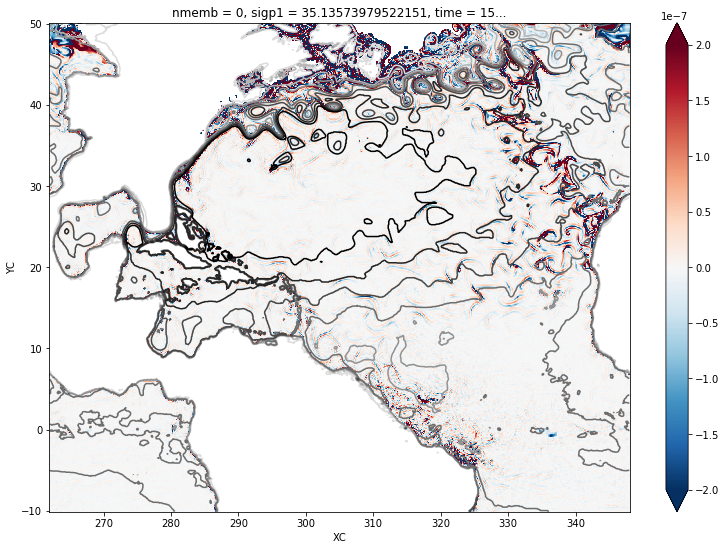

In [94]:
fig, ax = plt.subplots(figsize=(13,9))
cs = zeta[0,:,:,24].plot.contour(ax=ax, levels=np.linspace(0,500,8), cmap='binary')
for c in cs.collections:
    c.set_rasterized(True)
varpi[0,:,:,24].plot(ax=ax, vmax=2e-7, rasterized=True)

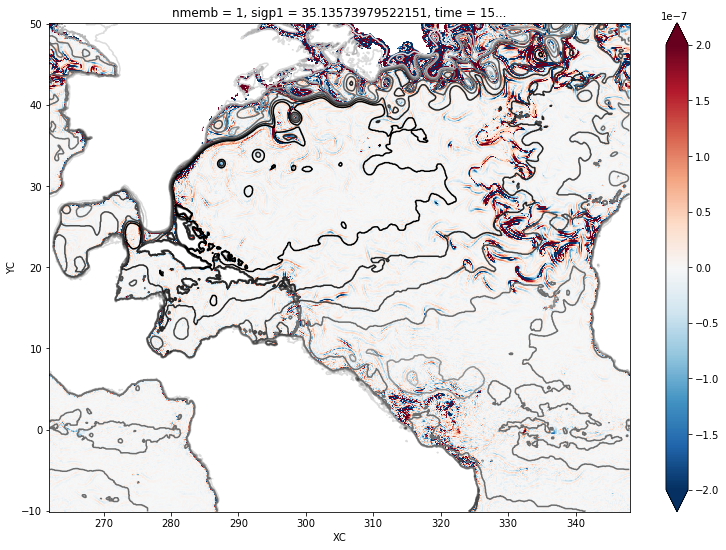

In [95]:
fig, ax = plt.subplots(figsize=(13,9))
cs = zeta[1,:,:,24].plot.contour(ax=ax, levels=np.linspace(0,500,8), cmap='binary')
for c in cs.collections:
    c.set_rasterized(True)
varpi[1,:,:,24].plot(ax=ax, vmax=2e-7, rasterized=True)